In [2]:
import numpy as np
import pandas as pd

ml_results = pd.read_csv("ml-1m_evaluation_results.csv")
lastfm_results = pd.read_csv("lastfm_evaluation_results.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'ml-1m_evaluation_results.csv'

In [ ]:
metrics_to_plot = ['Pre@10', 'Rec@10', 'Hit@10', 'MAP@10', 'NDCG@10', 'NDCG@10(M)', 'NDCG@10(F)', 'UGF-NDCG@10',
                   'IC@10(M)', 'IC@10(F)', 'UGF-IC@10', 'IC@10', 'AP@10', 'SE@10', 'GI@10', 'TP@10']
acc_metrics = ['Pre@10', 'Hit@10', 'Rec@10', 'MAP@10', 'NDCG@10']
user_fair_metrics = ['NDCG@10(M)', 'NDCG@10(F)', 'UGF-NDCG@10', 'IC@10(M)', 'IC@10(F)', 'UGF-IC@10']
item_fair_metrics = ['IC@10', 'AP@10', 'SE@10', 'GI@10', 'TP@10']

NameError: name 'ml_results' is not defined

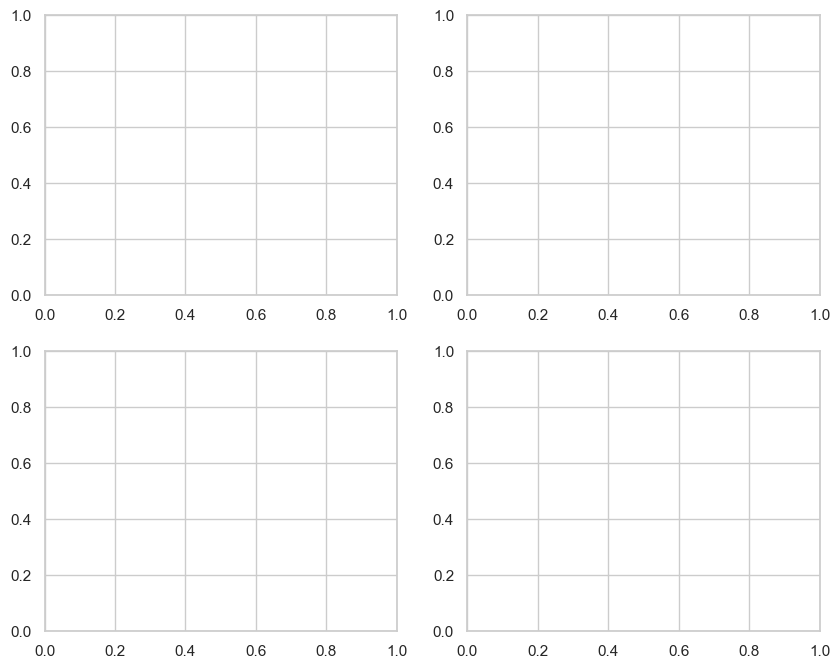

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.0)

# Fairness–accuracy pairs
tradeoff_pairs = [
    ("NDCG@10", "UGF-NDCG@10", "User Fairness (NDCG Gap) vs Accuracy (ML-1M)"),
    ("NDCG@10", "UGF-IC@10", "User Fairness (IC Gap) vs Accuracy (ML-1M)"),
    ("NDCG@10", "GI@10", "Item Fairness (Gini Index) vs Accuracy (ML-1M)"),
    ("NDCG@10", "TP@10", "Item Fairness (Tail Exposure) vs Accuracy (ML-1M)"),
]

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for i, (x_col, y_col, title) in enumerate(tradeoff_pairs):
    ax = axes[i]

    sns.scatterplot(
        data=ml_results,
        x=x_col, y=y_col,
        hue="Method", style="Method", s=100, ax=ax
    )

    ax.set_title(title, fontsize=12)
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)

    # Collect legend info only from the first plot
    if i == 0:
        handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()

# Add shared legend
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.02),
           ncol=len(labels), frameon=True, fontsize=11)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 原始方向设置
metrics_direction = {
    'NDCG@10': 'max',
    'UGF-NDCG@10': 'min',
    'UGF-IC@10': 'min',
    'GI@10': 'min',
    'TP@10': 'max',
}

# 归一化
df_norm = df_results.copy()
scaler = MinMaxScaler()

for metric, direction in metrics_direction.items():
    if direction == 'min':
        df_norm[metric] = 1 - scaler.fit_transform(df_results[[metric]])
    else:
        df_norm[metric] = scaler.fit_transform(df_results[[metric]])

# 权重方案
scenarios = {
    'Accuracy-Oriented': {'NDCG@10': 1.0},
    'User-Fairness-Oriented': {
        'NDCG@10': 0.2, 'UGF-NDCG@10': 0.4, 'UGF-IC@10': 0.2, 'GI@10': 0.1, 'TP@10': 0.1},
    'Item-Fairness-Oriented': {
        'NDCG@10': 0.2, 'UGF-NDCG@10': 0.1, 'UGF-IC@10': 0.1, 'GI@10': 0.4, 'TP@10': 0.2},
    'Balanced': {
        'NDCG@10': 0.4, 'UGF-NDCG@10': 0.2, 'UGF-IC@10': 0.1, 'GI@10': 0.2, 'TP@10': 0.1},
}

# 计算得分
score_table = {}
for name, weights in scenarios.items():
    score = sum(df_norm[k] * w for k, w in weights.items())
    score_table[name] = score

results_df = pd.DataFrame(score_table)
results_df['Method'] = df_results['Method']  # 添加方法名
results_df = results_df.set_index('Method')

# 加粗最优值
latex_df = results_df.copy()
for col in latex_df.columns:
    best_val = latex_df[col].max()
    tolerance = 1e-6
    latex_df[col] = [
        f"\\textbf{{{v:.3f}}}" if abs(v - best_val) < tolerance else f"{v:.2f}"
        for v in latex_df[col]
    ]

# 输出 LaTeX 表格
latex_output = latex_df.reset_index().to_latex(
    index=False,
    escape=False,
    column_format='l' + 'c' * (len(latex_df.columns)),
    caption="Scenario-wise Weighted Scores for Each Method",
    label="tab:scenario_scores"
)

print(latex_output)

